In [1]:
import zipfile
import os


def get_mydata_recognizer_dataset (mother_dir, cache_dir):
  fin = []
  zipfile.ZipFile(cache_dir, 'r').extractall(f'{mother_dir}/extracted')
  with open(f'{mother_dir}/extracted/mydata_recognition_data/groundtruth.csv', 'r') as f:
      lines = f.readlines()
      #print(lines)
      for data in lines:
          data = data.replace('\n','')
          filename, something, gt = data.split(',')
          filename = f'{mother_dir}/extracted/mydata_recognition_data/images/{filename}'
          something = None
          gt = gt.lower()
          tup = (filename, something, gt)
          fin.append(tup)
  return fin


mother_dir = '.'
cache_dir = 'mydata_recognition_data.zip'

dataset = get_mydata_recognizer_dataset(mother_dir, cache_dir=cache_dir)
print(dataset)

[('./extracted/mydata_recognition_data/images/ak1165.png', None, 'fuw999'), ('./extracted/mydata_recognition_data/images/ak399.png', None, 'fgj235'), ('./extracted/mydata_recognition_data/images/ak721.png', None, 'fhg521'), ('./extracted/mydata_recognition_data/images/ak848.png', None, 'fpj331'), ('./extracted/mydata_recognition_data/images/al1156.png', None, '6a5730a'), ('./extracted/mydata_recognition_data/images/al1181.png', None, '26a178n'), ('./extracted/mydata_recognition_data/images/al1204.png', None, '9a9990a'), ('./extracted/mydata_recognition_data/images/al1247.png', None, '47a434f'), ('./extracted/mydata_recognition_data/images/al1259.png', None, 'kaa20c'), ('./extracted/mydata_recognition_data/images/al145.png', None, '47a8d4c'), ('./extracted/mydata_recognition_data/images/al1528.png', None, '1g3296b'), ('./extracted/mydata_recognition_data/images/al1662.png', None, '2a3633a'), ('./extracted/mydata_recognition_data/images/al47.png', None, '2a9043j'), ('./extracted/mydata_r

In [2]:
mother_dir = '.'
cache_dir = 'mydata_recognition_data.zip'

train_labels = get_mydata_recognizer_dataset(mother_dir, cache_dir=cache_dir)
train_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]

In [3]:
import keras_ocr
import imgaug

import random
import string
import math
import itertools
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

tf.config.list_physical_devices() # Check H/W accellerator type

2024-12-15 04:15:37.801089: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-15 04:15:37.826594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734203737.844029   37400 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734203737.850775   37400 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 04:15:37.881499: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # GPU 커널 연산을 어느 정도 결정론적으로 만듦

# 2. 파이썬, NumPy, TF 시드 고정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [16]:
recognizer = keras_ocr.recognition.Recognizer()
recognizer.compile()
recognizer.training_model.optimizer.learning_rate.assign(0.00001)

Looking for /home/kyudan/.keras-ocr/crnn_kurapan.h5


<tf.Tensor: shape=(), dtype=float32, numpy=9.999999747378752e-06>

In [6]:
# Splitting train dataset into training+validation sets
import imgaug.augmenters as iaa

batch_size = 8
augmenter = iaa.Sequential([
    iaa.GammaContrast(gamma=(0.25, 3.0))
    
    
    #iaa.Dropout(p=(0, 0.1)),  # 픽셀 드롭아웃
])

train_labels, validation_labels = sklearn.model_selection.train_test_split(train_labels, test_size=0.2, random_state=SEED)
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]     
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size,
        
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras_ocr



# Define variables
m = 5  # Number of epochs per segment
n = 10   # Number of repetitions

# Callbacks for training
"""reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-8
)"""

# Prepare to store val_loss for both methods
val_loss_segmented = []
val_loss_linear = []



In [17]:
val_loss_segmented = []
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

#checkpoint_path = 'best.weights.h5'
for i in range(n):
    print(f"Segmented Training: Repetition {i+1}/{n}")
    
    # 각 세그먼트마다 체크포인트 생성
    checkpoint_path = f'best_segment_{i+1}.weights.h5'
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
    
    history = recognizer.training_model.fit(
        training_gen,
        steps_per_epoch=training_steps,
        validation_steps=validation_steps,
        validation_data=validation_gen,
        epochs=m,
        callbacks=[checkpoint_callback],
        verbose=1
    )
    
    # 이 세그먼트에서 val_loss가 가장 낮았던 epoch의 가중치 로드
    recognizer.training_model.load_weights(checkpoint_path)
    
    # validation loss 기록
    val_loss_segmented.extend(history.history['val_loss'])

Segmented Training: Repetition 1/10
Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 25.0732
Epoch 1: val_loss improved from inf to 26.03672, saving model to best_segment_1.weights.h5
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 24.9948 - val_loss: 26.0367
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 12.8788
Epoch 2: val_loss improved from 26.03672 to 11.54966, saving model to best_segment_1.weights.h5
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 12.8706 - val_loss: 11.5497
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 10.6123
Epoch 3: val_loss improved from 11.54966 to 10.30204, saving model to best_segment_1.weights.h5
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 10.6092 - val_loss: 10.3020
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 9.7271
Epoch 4: val_loss improved from 10.30204 to 9.78522, saving model to best_segment_1.weights.h5
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 9.7226 - val_loss: 9.7852
Epoch 5/5
75/75 ━━━━━

In [9]:
linear_model = keras_ocr.recognition.Recognizer()
linear_model.compile()

linear_model.training_model.optimizer.learning_rate.assign(0.00001)
# Method 2: Linear training
print("Linear Training")
history_linear = linear_model.training_model.fit(
    training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    #callbacks=[reduce_lr],
    epochs=m*n,
    verbose=1
)
val_loss_linear.extend(history_linear.history['val_loss'])


Looking for /home/kyudan/.keras-ocr/crnn_kurapan.h5
Linear Training
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 25.9989 - val_loss: 26.1590
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 12.1509 - val_loss: 11.4603
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 10.8538 - val_loss: 10.1044
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 10.0247 - val_loss: 9.4245
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 8.5179 - val_loss: 8.8499
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 8.0062 - val_loss: 8.3152
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 6.8172 - val_loss: 8.4688
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 6.3795 - val_loss: 7.5321
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 5.9678 - val_loss: 7.7765
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 5.6520 - val_loss: 7.1522
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 5.0793 - val_l

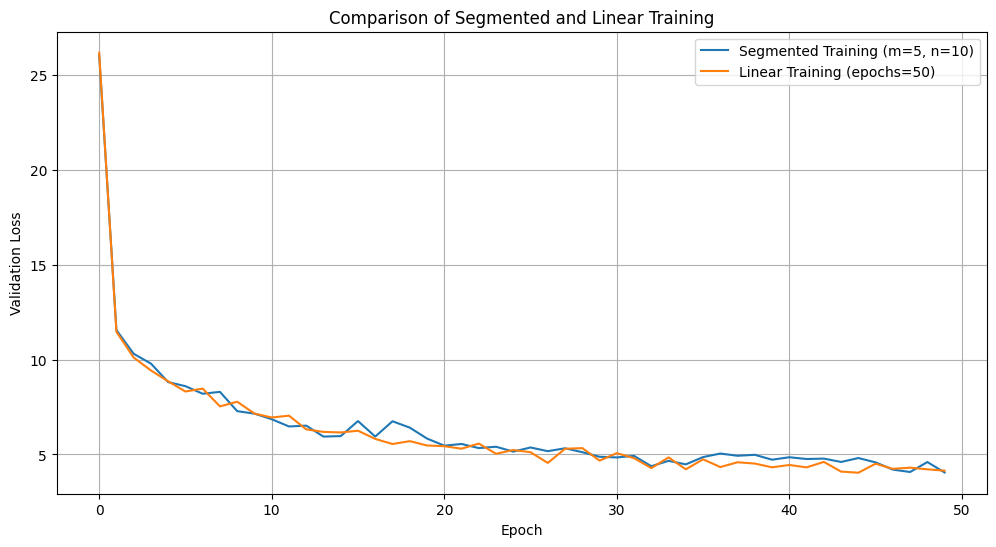

In [18]:

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(val_loss_segmented, label=f"Segmented Training (m={m}, n={n})")
plt.plot(val_loss_linear, label=f"Linear Training (epochs={m*n})")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.title("Comparison of Segmented and Linear Training")
plt.grid()
plt.show()